In [1]:
import sys
sys.path.append("../scripts/")
from GridMap import *
from RRT import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
import numpy as np
import math
import random
import copy

In [2]:
class RRTstar(RRT):
    def __init__(self, grid_map_world, ratioPointGoal=0.9, R=3):
        super(RRTstar, self).__init__(grid_map_world, ratioPointGoal=0.9)
        self.marker_size = 6
        self.R = R
        self.epsilon =0.1*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)
        self.start_cordinate = [(self.world.start_index[0]+1/2)*self.world.grid_step[0], (self.world.start_index[1]+1/2)*self.world.grid_step[1]]
        self.goal_cordinate = [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
    
    def draw(self, ax, elems):
        print(len(self.id))
        if(self.isStart):
            x, y = self.start_cordinate
            #ax.plot(x, y, marker='.', markersize=self.marker_size, color="blue")
            self.vertex.append([x, y, 0.0])
            self.parent.append(0)
            self.isStart = False
            self.id.append([x, y])
        
        xn, yn = None, None
        xp, yp = None, None
        xp_n, yp_n = None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #結べる点が得られるまで繰り返す
            #サンプリング
            if(random.random() > self.ratePointGoal and not(self.isFinish)):
                xp, yp = self.goal_cordinate   #ある確率でゴールを選択する
            else:
                r1 = random.random()
                r2 = random.random()
                xp = self.world.grid_num[0]*self.world.grid_step[0]*r1
                yp = self.world.grid_num[1]*self.world.grid_step[1]*r2
                xp, yp = self.returnGoalGrid([xp, yp])
                if(self.isObstacle([xp, yp])):
                    continue
            
            candidate = copy.copy(self.vertex)
            while(1):
                xn, yn, xp_n, yp_n, cost_n, nearest_id = self.getNearestVertex([xp, yp], candidate)    #[xp, yp]に最も近い頂点を探索
                if(self.isGoal([xn, yn])):
                    [xn, yn] = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #隣接ノードと半径1.1 grid_step以内であれば除外する
                #障害物に当たったりマップ外に出たりした場合はxn=xp_n, yn=yp_n
                if(math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2) < 0.001*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                    candidate.pop(nearest_id)
                    if(candidate == []):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2)
        self.vertex.append([xn, yn, cost_new])
        self.edge.append([xn, yn, xp_n, yp_n])
        self.parent.append([xp_n, yp_n])
        self.id.append([xn, yn])
        
        #エッジの変更
        for neigbor in self.getNeigborVertex([xn, yn]):
            if(neigbor[2] > cost_new + math.sqrt((xn-neigbor[0])**2 + (yn-neigbor[1])**2)):
                isCollision, _, _ = self.collisionFree(neigbor,[xn, yn],  type2=False)
                if(isCollision == 0 or isCollision == 2):
                    continue
                parent_vertex = self.parent[self.get_id([neigbor[0], neigbor[1]])]
                self.edge.remove([neigbor[0], neigbor[1], parent_vertex[0], parent_vertex[1]])
                self.edge.append([neigbor[0], neigbor[1], xn, yn])
                self.parent[self.get_id([neigbor[0], neigbor[1]])] = [xn, yn]
                self.changeChildCost(neigbor)
        
        #頂点とエッジを描画
        elems += ax.plot(xp, yp, marker='.', color="red")
        #elems += ax.plot(xn, yn, marker='.', color="black", markersize=7)
        #elems += ax.plot([xp_n, xn], [yp_n, yn], color="blue")
        #elems.append(ax.add_patch(circle = patches.Circle(xy=(xn, yn),radius=self.R * math.pow(math.log(len(self.vertex))/len(self.vertex), 1/2.0),fc='g', ec='g',alpha=0.5)))
        for edge in self.edge:
            x1, y1, x2, y2 = edge
            elems += ax.plot([x1, x2], [y1, y2], color="cyan", alpha=0.5)
        c = "blue"

        cost_adj1, cost_adj2 = 100, 0
        c_num = int(cost_adj1 * (cost_new - cost_adj2)) #Black→Blue
        #print(cost_new, c_num)
        if(c_num > 0xff): #Blue → Cyan
            c_num = (c_num-0xff)*256 + 0xff
            if(c_num > 0xffff): #Cyan → Green
                c_num = 0xffff - int((c_num-0x100ff)*1/256)
                if(c_num < 0xff00): #Green →Yellow
                    c_num = (0xff00-c_num)*65536+0xff00
                    if(c_num > 0xffff00): #Yellow → Red
                        c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
        fill = True
        alpha = 0.5
        c = '#' + format(int(c_num), 'x').zfill(6)
        #ax.plot(xn, yn, marker='.', markersize=self.marker_size, color=c, alpha=0.5)
        
        #経路の描画
        if(self.isFinish):
            #ゴールからスタート
            id = self.get_id(self.goal_cordinate)
            distance = 0
            while(id != 0):    #スタート（id=0）になるまで繰り返す
                x1, y1 = self.id[id]
                x2, y2 = self.parent[id]
                id = self.get_id([x2, y2])
                elems += ax.plot([x1, x2], [y1, y2], color="red")
                distance += math.sqrt((x1-x2)**2 + (y1-y2)**2)
            dis_str ="Distance = %.2f" % (distance)
            elems.append(
                ax.text(
                    self.world.grid_step[0]*self.world.grid_num[0]*0.6,
                    self.world.grid_step[1]*self.world.grid_num[1]*1.02,
                    dis_str,
                    fontsize=10
                )
            )
    
    #最も近い頂点を探し，2つの頂点の座標とコストを返す
    def getNearestVertex(self, xNew, candidate):
        dis = float('inf')
        dis_collision = float('inf')
        xNearest = []
        xNearest_collision = []
        cost_n = 0
        cost_n_collision = 0
        nearest_id = 0
        nearest_id_collision = 0
        for x in candidate:
            if(dis > x[2] + (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                dis = x[2] + (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                xNearest = [x[0], x[1]]
                cost_n = x[2]
                nearest_id = candidate.index([x[0], x[1], x[2]])
                    
        if(xNearest == []):
            xNearest = xNearest_collision
            cost_n_collision = cost_n
            nearest_id = nearest_id_collision            
        
        isCollision = self.collisionFree(xNearest, xNew, type2=False)
        if(isCollision[0] == 0):
            return xNearest[0], xNearest[1], xNearest[0], xNearest[1], cost_n, nearest_id
        elif(isCollision[0] == 2):
            return isCollision[1], isCollision[2], xNearest[0], xNearest[1], cost_n, nearest_id
        else:
            return xNew[0], xNew[1], xNearest[0], xNearest[1], cost_n, nearest_id
    
    
    #近傍にあるすべての頂点を返す
    def getNeigborVertex(self, x):
        N = len(self.vertex)
        r = self.R * math.pow(math.log(N)/N, 1/2)
        neigbors = []
        for vertex in self.vertex:
            if(math.sqrt((x[0]-vertex[0])**2 + (x[1]-vertex[1])**2) < r):
                if([vertex[0], vertex[1]] != x):
                    neigbors.append(vertex)
        return neigbors
    
    def changeChildCost(self, vertex):
        id = self.get_id([vertex[0], vertex[1]])
        parent = self.parent[self.get_id([vertex[0], vertex[1]])]
        parent_id = self.get_id([parent[0], parent[1]])
        self.vertex[id][2] = self.vertex[parent_id][2] + math.sqrt((vertex[0]-parent[0])**2 + (vertex[1]-parent[1])**2)
        for child in self.get_children(vertex):
            self.changeChildCost(child)
    
    def get_children(self, x):
        parent_id = self.get_id([x[0], x[1]])
        children = []
        for child_candidate in self.vertex:
            child_id = self.get_id([child_candidate[0], child_candidate[1]])
            if(self.parent[child_id] == parent_id):
                children.append(self.vertex[child_id])
        return children

<IPython.core.display.Javascript object>


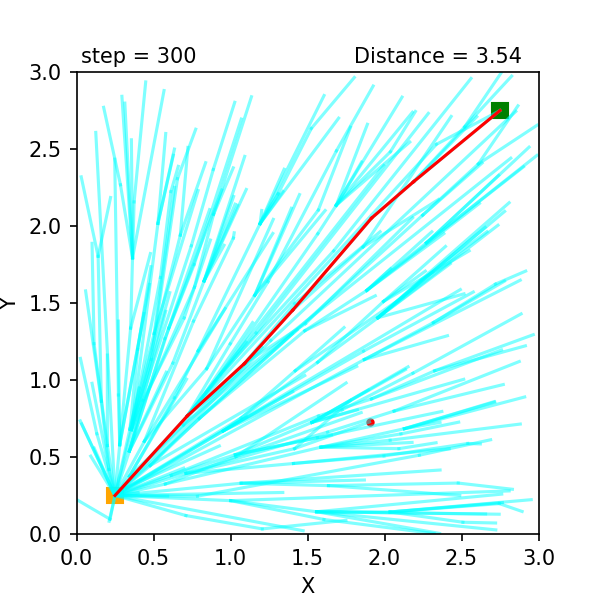

In [3]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map1.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(RRTstar(world, R=7, ratioPointGoal=0.95))
    
    world.draw()
    #world.ani.save('input_informed.gif', writer='pillow', fps=100)    #アニメーション保存